In [1]:
# fmt: off
import numpy as np
import matplotlib.pyplot as plt
from InterpretabilityMethods import *
from SequentialTask import *
from EWCMethods import EWC_Method

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
# fmt: on

In [2]:
MODEL_SAVE_PATH = "models/mnist_intepretability_model"
TRAIN_MODEL = False
LOAD_MODEL = True

task_digit_labels = [0,1]
epochs = 5
training_batches = 300
validation_batches = 100
batch_size = 32
ewc_method = EWC_Method.NONE

In [3]:
model: tf.keras.Model
if LOAD_MODEL and os.path.exists(MODEL_SAVE_PATH):
    # Try to load model directly, if one exists
    print("LOADING MODEL")
    model = tf.keras.models.load_model(MODEL_SAVE_PATH,compile=False)  # type: ignore
else:
    # Otherwise, make an entire new model!
    print("CREATING MODEL")
    model_input_shape = (28,28,1)
    model_inputs = model_layer = tf.keras.Input(shape=model_input_shape)
    model_layer = tf.keras.layers.Conv2D(12, (5,5), activation="relu")(model_layer)
    model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(12, (4,4), activation="relu")(model_layer)
    model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(12, (4,4), activation="relu")(model_layer)
    model_layer = tf.keras.layers.Flatten()(model_layer)
    model_layer = tf.keras.layers.Dense(10, activation="relu")(model_layer)
    model_layer = tf.keras.layers.Dense(len(task_digit_labels))(model_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=model_layer, name="model")

if len(task_digit_labels) == 2:
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
else:
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.summary()

LOADING MODEL
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 12)        312       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 12)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 12)          2316      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 12)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 12)  

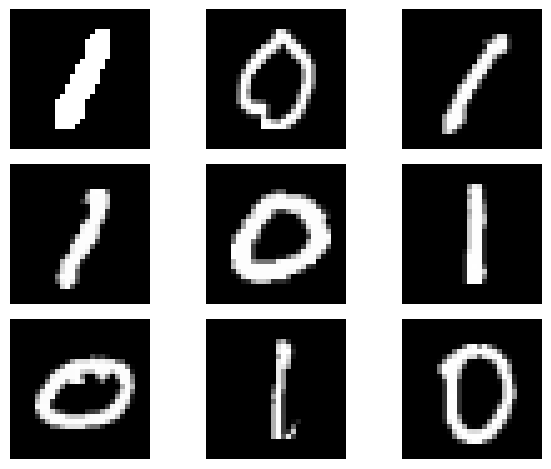

In [14]:
task = MNISTClassificationTask(
        name=f"Task 0",
        model=model,
        model_base_loss=loss_fn,
        task_digit_labels=task_digit_labels,
        training_batches = training_batches,
        validation_batches = validation_batches,
        batch_size=batch_size
    )
task.compile_model(loss_fn)

# Show some images from the task dataset
batch = task.training_dataset.take(1).get_single_element()
images = batch[0][:9]
plot_images(images, cmap="gray")

In [13]:
if TRAIN_MODEL:
    checkpoint_path = MODEL_SAVE_PATH+"/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=1)

    history = task.train_on_task(epochs=epochs, callbacks=[
        # checkpoint_callback,
    ])
    model.save(MODEL_SAVE_PATH)

In [ ]:
kernel_inspection(model=task.model, layer_index=5, steps=1000, step_size=0.05)

In [12]:
def occlusion_sensitivity(
    model: tf.keras.Model,
    data: tf.data.Dataset,
    num_items: int,
    patch_size: int = 3,
    stride: int = 1):
    """
    Compute sensitivity to a series of data points by occluding a section of the image
    Occlusion is shifted across the image, with loss being computed at each step

    Parameters:
        model: tf.keras.Model
            The model to test sensitivity of
        data: tf.data.Dataset
            The data to test over. Should be a subsection of the entire dataset
            Use data.take() to get a small subset of data first
            Each image is processed, so the size of this dataset is number of images
        num_items: int
            The number of items to process overall (from the dataset)
        patch_size: int
            The size of the patch use for occlusion
        stride: int
            The amount to move the patch between trials
            Currently unused (stride = patch_size)
    """

    processed_images = 0

    # Loop over each batch in the dataset
    for batch in data:
        # Pull out the image/label pair from tuple
        # Each of these variables have dimension starting with batch_size
        # So zip them together to get image, label pairs directly
        images = batch[0]
        labels = batch[1]
        for image, label in zip(images, labels):
            # Convert the image to something more... manageable
            # Remove first index (added from tf dataset)
            # convert to numpy array
            image: np.ndarray = np.array(image)  # type: ignore
            sensitivity_map = np.zeros((image.shape[0], image.shape[1]))
            patched_images = []
            # Loop over every possible position of the occulsion square
            # note for now the stride is simply the patch size, i.e.
            # disjoint patches
            for top_left_y in range(0, image.shape[0],patch_size):
                for top_left_x in range(0, image.shape[1],patch_size):
                    # Copy the original image, apply a square of black over that patch
                    patched_image = np.array(image, copy=True)
                    patched_image[
                        top_left_y:top_left_y+patch_size,
                        top_left_x:top_left_x+patch_size, 
                        : 
                    ] = 0.0
                    # We collect all the patched images together to be processed in a single batch
                    patched_images.append(patched_image)
            patched_images = np.array(patched_images)
            # Note multiplying by label, we are only interested in 
            # model predicted likelihood of correct class
            predictions = model(patched_images) * label
            # Loop over predictions and apply confidence to the sensitivity map
            prediction_index = 0
            for top_left_y in range(0, image.shape[0],patch_size):
                for top_left_x in range(0, image.shape[1],patch_size):
                    confidence = predictions[prediction_index] 
                    sensitivity_map[
                        top_left_y:top_left_y+patch_size,
                        top_left_x:top_left_x+patch_size,
                    ] = confidence
            # Finally finished with one image! Check if we have met quota
            processed_images += 1
            if processed_images >= num_items:
                break

data = task.validation_dataset.take(1)
occlusion_sensitivity(task.model,data,num_items=9)